In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ot
import tqdm
import sklearn.decomposition
import sklearn.cluster
import itertools
import time
import umap

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [4]:
from src.utils import *
from src.encoders_decoders import *
from src.dwe import *
from src.data_mining import *

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# W^p

In [7]:
ds = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [8]:
def create_train_test(ds, test_ds, n_train, n_test, p=2):
    train_dataset = DWE_dataset(ds, n_train, p=p)
    test_dataset = DWE_dataset(test_ds, n_test, p=p)
    return train_dataset, test_dataset

In [9]:
def create_model(cuda=True, regterm=1):
    e = EncoderCNN()
    d = DecoderCNN()
    m = DWE(e, d, regterm, cuda=cuda, lr=1e-3, from_dir=None, name='mnist')
    return m

In [10]:
def train_model(m, ds, batch_size=64, nepochs=10):
    kwargs = {'num_workers': 1, 'pin_memory': True} if m.cuda else {}
    train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, **kwargs)
    m.train(train_loader, has_y=True, nepochs=nepochs)

In [11]:
def eval_test(m, ds, batch_size=128, has_y=True):
    preds = []
    ys = []
    kwargs = {'num_workers': 1, 'pin_memory': True} if m.cuda else {}
    test_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, **kwargs)
    with torch.no_grad():
        for x1, x2, y in tqdm.tqdm_notebook(test_loader, desc='Evaluating'):
            if has_y:
                x1 = x1[0]
                x2 = x2[0]
            if m.cuda:
                x1 = x1.cuda()
                x2 = x2.cuda()
            phi1 = m.encoder(x1).detach().cpu().numpy()
            phi2 = m.encoder(x2).detach().cpu().numpy()
            pred = list(((phi1 - phi2)**2).sum(axis=1))
            preds.extend(pred)
            ys.extend(y)
    preds = np.array(preds)
    ys = np.array(ys)
    return preds, ys

In [12]:
def performance_ds(ds, test_ds, p, n_train=100000, n_test=10000, cuda=True):
    print(f'p = {p}')
    train_dataset, test_dataset = create_train_test(ds, test_ds, n_train, n_test, p=p)
    m = create_model(cuda, regterm=1)
    train_model(m, train_dataset, batch_size=64)
    preds, ys = eval_test(m, test_dataset)
    err = np.abs(preds - ys)
    print(f'Error : {err.mean():.3f}+-{err.std():.3f}')
    print(f'Relative MAE = {((err)/(ys + 1e-9)).mean():.3f}')
    print(f'MSE = {((ys - preds)**2).mean():.3f}')
    print(f'Relative MSE = {(((ys - preds)**2)/(ys + 1e-9)).mean():.3f}')
    print(f'Correlation = {np.corrcoef(np.stack((preds, ys)))[0, 1]:.3f}')
    print(f'Error quantiles : 1% : {np.quantile(err, 0.01):.2f}| 50% : {np.quantile(err, 0.5):.2f}| 99% : {np.quantile(err, 0.99):.2f}')
    print(f'Mean distance : {ys.mean():.2f}')
    print()
    return preds, ys

In [13]:
list_p = np.geomspace(0.02, 20, 10)
print(list_p)
data = {}
for p in list_p:
    preds, ys = performance_ds(ds, test_ds, p, n_train=100000, n_test=30000, cuda=True)
    data[p] = (preds, ys)

[ 0.02        0.04308869  0.09283178  0.2         0.43088694  0.92831777
  2.          4.30886938  9.28317767 20.        ]
p = 0.020000000000000004


Mean train loss : 24.72 (Wasserstein : 20.91 - data : 3.81)
Mean train accuracy : 2.88
Mean train loss : 4.41 (Wasserstein : 2.55 - data : 1.86)
Mean train accuracy : 1.24
Mean train loss : 3.23 (Wasserstein : 1.80 - data : 1.43)
Mean train accuracy : 1.04
Mean train loss : 2.84 (Wasserstein : 1.59 - data : 1.25)
Mean train accuracy : 0.97
Mean train loss : 2.54 (Wasserstein : 1.44 - data : 1.10)
Mean train accuracy : 0.92
Mean train loss : 2.37 (Wasserstein : 1.35 - data : 1.02)
Mean train accuracy : 0.89
Mean train loss : 2.25 (Wasserstein : 1.27 - data : 0.97)
Mean train accuracy : 0.87
Mean train loss : 2.03 (Wasserstein : 1.18 - data : 0.85)
Mean train accuracy : 0.83
Mean train loss : 1.95 (Wasserstein : 1.14 - data : 0.81)
Mean train accuracy : 0.82
Mean train loss : 2.72 (Wasserstein : 1.45 - data : 1.27)
Mean train accuracy : 0.91




Error : 0.944+-0.769
Relative MAE = 0.096
MSE = 1.482
Relative MSE = 0.131
Correlation = 0.984
Error quantiles : 1% : 0.01| 50% : 0.76| 99% : 3.40
Mean distance : 11.14

p = 0.04308869380063767


Mean train loss : 45.49 (Wasserstein : 40.62 - data : 4.87)
Mean train accuracy : 4.18
Mean train loss : 5.54 (Wasserstein : 3.38 - data : 2.16)
Mean train accuracy : 1.43
Mean train loss : 3.44 (Wasserstein : 1.96 - data : 1.49)
Mean train accuracy : 1.08
Mean train loss : 2.95 (Wasserstein : 1.70 - data : 1.25)
Mean train accuracy : 1.00
Mean train loss : 2.61 (Wasserstein : 1.48 - data : 1.12)
Mean train accuracy : 0.94
Mean train loss : 2.38 (Wasserstein : 1.35 - data : 1.03)
Mean train accuracy : 0.89
Mean train loss : 2.24 (Wasserstein : 1.29 - data : 0.95)
Mean train accuracy : 0.87
Mean train loss : 2.16 (Wasserstein : 1.24 - data : 0.91)
Mean train accuracy : 0.85
Mean train loss : 2.10 (Wasserstein : 1.22 - data : 0.88)
Mean train accuracy : 0.85
Mean train loss : 2.01 (Wasserstein : 1.17 - data : 0.84)
Mean train accuracy : 0.83




Error : 0.811+-0.681
Relative MAE = 0.086
MSE = 1.122
Relative MSE = 0.106
Correlation = 0.983
Error quantiles : 1% : 0.01| 50% : 0.65| 99% : 3.08
Mean distance : 11.14

p = 0.09283177667225556


Mean train loss : 29.86 (Wasserstein : 24.78 - data : 5.08)
Mean train accuracy : 3.24
Mean train loss : 4.67 (Wasserstein : 2.77 - data : 1.90)
Mean train accuracy : 1.29
Mean train loss : 3.35 (Wasserstein : 1.98 - data : 1.37)
Mean train accuracy : 1.08
Mean train loss : 2.89 (Wasserstein : 1.72 - data : 1.17)
Mean train accuracy : 1.01
Mean train loss : 2.64 (Wasserstein : 1.57 - data : 1.07)
Mean train accuracy : 0.96
Mean train loss : 2.44 (Wasserstein : 1.46 - data : 0.98)
Mean train accuracy : 0.93
Mean train loss : 2.33 (Wasserstein : 1.41 - data : 0.93)
Mean train accuracy : 0.91
Mean train loss : 2.20 (Wasserstein : 1.33 - data : 0.86)
Mean train accuracy : 0.88
Mean train loss : 2.08 (Wasserstein : 1.25 - data : 0.83)
Mean train accuracy : 0.86
Mean train loss : 1.98 (Wasserstein : 1.21 - data : 0.77)
Mean train accuracy : 0.84




Error : 0.811+-0.698
Relative MAE = 0.087
MSE = 1.145
Relative MSE = 0.107
Correlation = 0.984
Error quantiles : 1% : 0.01| 50% : 0.64| 99% : 3.15
Mean distance : 11.07

p = 0.20000000000000004


Mean train loss : 31.88 (Wasserstein : 25.09 - data : 6.79)
Mean train accuracy : 3.14
Mean train loss : 5.66 (Wasserstein : 2.98 - data : 2.67)
Mean train accuracy : 1.34
Mean train loss : 3.39 (Wasserstein : 1.94 - data : 1.45)
Mean train accuracy : 1.08
Mean train loss : 2.87 (Wasserstein : 1.64 - data : 1.24)
Mean train accuracy : 0.98
Mean train loss : 2.51 (Wasserstein : 1.43 - data : 1.09)
Mean train accuracy : 0.92
Mean train loss : 2.29 (Wasserstein : 1.31 - data : 0.98)
Mean train accuracy : 0.87
Mean train loss : 3.71 (Wasserstein : 1.63 - data : 2.08)
Mean train accuracy : 0.96
Mean train loss : 2.21 (Wasserstein : 1.23 - data : 0.98)
Mean train accuracy : 0.84
Mean train loss : 1.98 (Wasserstein : 1.14 - data : 0.84)
Mean train accuracy : 0.81
Mean train loss : 1.83 (Wasserstein : 1.05 - data : 0.78)
Mean train accuracy : 0.78




Error : 0.805+-0.687
Relative MAE = 0.085
MSE = 1.121
Relative MSE = 0.104
Correlation = 0.986
Error quantiles : 1% : 0.01| 50% : 0.63| 99% : 3.11
Mean distance : 11.15

p = 0.43088693800637673


Mean train loss : 34.01 (Wasserstein : 29.35 - data : 4.66)
Mean train accuracy : 3.59
Mean train loss : 6.27 (Wasserstein : 3.89 - data : 2.38)
Mean train accuracy : 1.54
Mean train loss : 4.01 (Wasserstein : 2.32 - data : 1.69)
Mean train accuracy : 1.18
Mean train loss : 3.23 (Wasserstein : 1.82 - data : 1.41)
Mean train accuracy : 1.05
Mean train loss : 2.77 (Wasserstein : 1.55 - data : 1.22)
Mean train accuracy : 0.96
Mean train loss : 2.39 (Wasserstein : 1.36 - data : 1.04)
Mean train accuracy : 0.90
Mean train loss : 2.16 (Wasserstein : 1.23 - data : 0.93)
Mean train accuracy : 0.85
Mean train loss : 2.08 (Wasserstein : 1.19 - data : 0.89)
Mean train accuracy : 0.84
Mean train loss : 1.98 (Wasserstein : 1.14 - data : 0.84)
Mean train accuracy : 0.82
Mean train loss : 1.86 (Wasserstein : 1.09 - data : 0.78)
Mean train accuracy : 0.80




Error : 0.817+-0.683
Relative MAE = 0.087
MSE = 1.135
Relative MSE = 0.108
Correlation = 0.985
Error quantiles : 1% : 0.01| 50% : 0.65| 99% : 3.06
Mean distance : 11.18

p = 0.9283177667225556


Mean train loss : 28.13 (Wasserstein : 23.46 - data : 4.66)
Mean train accuracy : 3.20
Mean train loss : 4.58 (Wasserstein : 2.76 - data : 1.82)
Mean train accuracy : 1.29
Mean train loss : 3.28 (Wasserstein : 1.92 - data : 1.36)
Mean train accuracy : 1.07
Mean train loss : 2.90 (Wasserstein : 1.71 - data : 1.19)
Mean train accuracy : 1.01
Mean train loss : 2.53 (Wasserstein : 1.49 - data : 1.04)
Mean train accuracy : 0.94
Mean train loss : 2.39 (Wasserstein : 1.40 - data : 0.99)
Mean train accuracy : 0.91
Mean train loss : 3.56 (Wasserstein : 1.76 - data : 1.80)
Mean train accuracy : 1.01
Mean train loss : 2.28 (Wasserstein : 1.38 - data : 0.90)
Mean train accuracy : 0.90
Mean train loss : 2.14 (Wasserstein : 1.31 - data : 0.83)
Mean train accuracy : 0.88
Mean train loss : 2.25 (Wasserstein : 1.32 - data : 0.92)
Mean train accuracy : 0.88




Error : 0.909+-0.742
Relative MAE = 0.098
MSE = 1.377
Relative MSE = 0.131
Correlation = 0.983
Error quantiles : 1% : 0.01| 50% : 0.73| 99% : 3.36
Mean distance : 11.08

p = 2.0000000000000004


Mean train loss : 26.72 (Wasserstein : 21.54 - data : 5.18)
Mean train accuracy : 3.04
Mean train loss : 5.07 (Wasserstein : 3.04 - data : 2.03)
Mean train accuracy : 1.36
Mean train loss : 3.57 (Wasserstein : 2.08 - data : 1.49)
Mean train accuracy : 1.12
Mean train loss : 2.92 (Wasserstein : 1.71 - data : 1.20)
Mean train accuracy : 1.01
Mean train loss : 3.36 (Wasserstein : 1.70 - data : 1.66)
Mean train accuracy : 0.99
Mean train loss : 2.90 (Wasserstein : 1.68 - data : 1.22)
Mean train accuracy : 0.99
Mean train loss : 2.40 (Wasserstein : 1.41 - data : 0.99)
Mean train accuracy : 0.91
Mean train loss : 2.29 (Wasserstein : 1.35 - data : 0.94)
Mean train accuracy : 0.89
Mean train loss : 2.13 (Wasserstein : 1.26 - data : 0.87)
Mean train accuracy : 0.86
Mean train loss : 2.04 (Wasserstein : 1.19 - data : 0.85)
Mean train accuracy : 0.83




Error : 0.844+-0.726
Relative MAE = 0.087
MSE = 1.239
Relative MSE = 0.112
Correlation = 0.985
Error quantiles : 1% : 0.01| 50% : 0.67| 99% : 3.30
Mean distance : 11.12

p = 4.308869380063765


Mean train loss : 49.48 (Wasserstein : 44.43 - data : 5.05)
Mean train accuracy : 4.18
Mean train loss : 3.89 (Wasserstein : 2.17 - data : 1.72)
Mean train accuracy : 1.14
Mean train loss : 2.96 (Wasserstein : 1.65 - data : 1.31)
Mean train accuracy : 0.99
Mean train loss : 3.56 (Wasserstein : 1.64 - data : 1.93)
Mean train accuracy : 0.97
Mean train loss : 3.31 (Wasserstein : 1.88 - data : 1.43)
Mean train accuracy : 1.05
Mean train loss : 2.56 (Wasserstein : 1.58 - data : 0.98)
Mean train accuracy : 0.96
Mean train loss : 2.93 (Wasserstein : 1.52 - data : 1.41)
Mean train accuracy : 0.94
Mean train loss : 2.29 (Wasserstein : 1.44 - data : 0.85)
Mean train accuracy : 0.92
Mean train loss : 2.08 (Wasserstein : 1.28 - data : 0.80)
Mean train accuracy : 0.86
Mean train loss : 1.91 (Wasserstein : 1.14 - data : 0.77)
Mean train accuracy : 0.81




Error : 0.770+-0.651
Relative MAE = 0.084
MSE = 1.016
Relative MSE = 0.101
Correlation = 0.986
Error quantiles : 1% : 0.01| 50% : 0.61| 99% : 2.93
Mean distance : 11.16

p = 9.283177667225555


Mean train loss : 20.78 (Wasserstein : 17.04 - data : 3.75)
Mean train accuracy : 2.62
Mean train loss : 3.78 (Wasserstein : 2.19 - data : 1.59)
Mean train accuracy : 1.15
Mean train loss : 5.14 (Wasserstein : 2.24 - data : 2.90)
Mean train accuracy : 1.15
Mean train loss : 2.96 (Wasserstein : 1.76 - data : 1.20)
Mean train accuracy : 1.02
Mean train loss : 2.66 (Wasserstein : 1.58 - data : 1.08)
Mean train accuracy : 0.96
Mean train loss : 2.44 (Wasserstein : 1.48 - data : 0.96)
Mean train accuracy : 0.93
Mean train loss : 2.28 (Wasserstein : 1.40 - data : 0.88)
Mean train accuracy : 0.90
Mean train loss : 2.04 (Wasserstein : 1.25 - data : 0.79)
Mean train accuracy : 0.85
Mean train loss : 1.90 (Wasserstein : 1.15 - data : 0.75)
Mean train accuracy : 0.82
Mean train loss : 1.77 (Wasserstein : 1.06 - data : 0.70)
Mean train accuracy : 0.78




Error : 0.795+-0.691
Relative MAE = 0.082
MSE = 1.110
Relative MSE = 0.101
Correlation = 0.983
Error quantiles : 1% : 0.01| 50% : 0.62| 99% : 3.19
Mean distance : 11.07

p = 20.000000000000004


Mean train loss : 97.49 (Wasserstein : 90.56 - data : 6.93)
Mean train accuracy : 7.18
Mean train loss : 5.33 (Wasserstein : 3.00 - data : 2.33)
Mean train accuracy : 1.34
Mean train loss : 3.85 (Wasserstein : 2.30 - data : 1.55)
Mean train accuracy : 1.17
Mean train loss : 3.47 (Wasserstein : 2.07 - data : 1.40)
Mean train accuracy : 1.11
Mean train loss : 3.07 (Wasserstein : 1.84 - data : 1.24)
Mean train accuracy : 1.04
Mean train loss : 2.83 (Wasserstein : 1.69 - data : 1.14)
Mean train accuracy : 1.00
Mean train loss : 2.62 (Wasserstein : 1.55 - data : 1.07)
Mean train accuracy : 0.96
Mean train loss : 2.47 (Wasserstein : 1.47 - data : 1.00)
Mean train accuracy : 0.93
Mean train loss : 2.36 (Wasserstein : 1.41 - data : 0.95)
Mean train accuracy : 0.91
Mean train loss : 2.30 (Wasserstein : 1.38 - data : 0.92)
Mean train accuracy : 0.90




Error : 0.880+-0.724
Relative MAE = 0.096
MSE = 1.299
Relative MSE = 0.127
Correlation = 0.981
Error quantiles : 1% : 0.01| 50% : 0.71| 99% : 3.26
Mean distance : 11.08



In [21]:
errors = [0.944, 0.811, 0.811, 0.805, 0.817, 0.909, 0.844, 0.77, 0.795, 0.880]
std = [0.769, 0.681, 0.698, 0.687, 0.683, 0.742, 0.726, 0.651, 0.691, 0.724]

<IPython.core.display.Javascript object>


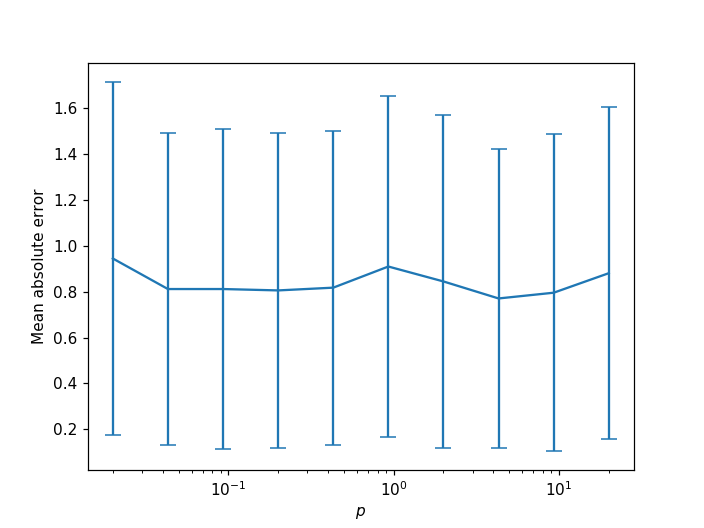

Text(0, 0.5, 'Mean absolute error')

In [29]:
fig, ax = plt.subplots()
ax.errorbar(list_p, errors, yerr=std, capsize=5)
ax.set_xscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel('Mean absolute error')